# Simple Black-box Adversarial Attack (SimBA) and Binary Input Detector Using CIFAR-10

This notebook demonstrates the implementation of the SimBA attack using the Adversarial Robustness Toolbox (ART) against a ResNet-18 model trained on the CIFAR-10 dataset. The tasks covered in this notebook are:

1. Load the Required Libraries
    
    The necessary Python libraries and modules are imported, including TensorFlow/Keras for model creation and ART for implementing the adversarial attack.

2. Load the Dataset and Inspect the Data
    
    The CIFAR-10 dataset, which consists of 60,000 color images in 10 classes, is loaded and inspected. This step includes visualizing sample images and understanding the data distribution.

3. Create a Deep Learning Model
    
    A ResNet-18 model is constructed to classify the CIFAR-10 images. ResNet-18, part of the Residual Network family, is chosen for its simplicity and effectiveness, featuring 18 layers including convolutional, batch normalization, and fully connected layers.

4. Train and Evaluate the Deep Learning Model on CIFAR-10 Test Data
    
    The ResNet-18 model is trained using the CIFAR-10 training set and subsequently evaluated on the test set to establish a baseline accuracy.

5. Implement SimBA Attack Using ART
    
    The Simple Black-box Attack (SimBA) is implemented using the ART library. SimBA is an efficient black-box adversarial attack that perturbs images by iteratively flipping the sign of individual pixels and checking the impact on the model's prediction. The attack operates by querying the model to observe changes in output without needing access to the model's internal parameters or gradients.

More about SimBA:

SimBA stands out for its simplicity and effectiveness in black-box scenarios where only the model's output is accessible. The attack involves:

*   Random Pixel Selection: Choosing random pixels to perturb in the input image.
*   Sign Flip: Flipping the sign of the selected pixel values to create perturbations.
*   Querying the Model: Evaluating the impact of each perturbation by querying the model and measuring the change in its output.
*   Iterative Process: Repeating the process iteratively to maximize the attack's success in causing misclassification with minimal perturbations.

6. Create Adversarial Samples Using the SimBA Attack
    
    Adversarial examples are generated from the original test images using the SimBA attack. These adversarial samples are visually inspected and compared with the original images.

7. Evaluate the Deep Learning Model Against the Adversarial Samples
    
    The robustness of the trained ResNet-18 model is evaluated by testing its accuracy on the generated adversarial samples, highlighting the model's vulnerability to adversarial attacks.

8. Create a Detector Model to Detect Adversarial Samples
    
    A binary classification model is developed to detect whether an input sample is adversarial or not. This involves designing a model that can differentiate between original and adversarial images based on specific features.

9. Train and Evaluate the Detector Model
    
    The detector model is trained using a labeled dataset containing both original and adversarial samples. The performance of the detector is then evaluated to determine its accuracy in identifying adversarial attacks.
----
This summary encapsulates the process and key tasks involved in implementing the SimBA attack and developing a binary input detector using the CIFAR-10 dataset and a ResNet-18 model. The inclusion of the SimBA attack illustrates an effective method to evaluate the robustness of machine learning models in black-box scenarios, emphasizing the importance of adversarial defenses in practical applications.

## Install and load required libraries 

In [1]:
# Install prerequired libraries.
# !pip install adversarial-robustness-toolbox

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
from matplotlib import pyplot as plt
# import pandas as pd

from art.utils import load_cifar10, preprocess, to_categorical

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import SimBA
from art.defences.detector.evasion import BinaryInputDetector

2024-05-29 13:52:55.136037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 13:52:55.522632: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[1], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


2024-05-29 13:53:05.021848: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 13:53:05.152716: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45977 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:73:00.0, compute capability: 7.5


## Load CIFAR-10 dataset

In [3]:
# (x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()
# Load the dataset from the local drive
data = np.load('./../datasets/cifar10_dataset.npz')
x_train, y_train, x_test, y_test= data['X_train'], data['y_train'], data['X_test'], data['y_test']

class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

min = x_train.min()
max = x_train.max()

x_train.shape, y_train.shape, x_test.shape, y_test.shape, min, max

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10), 0.0, 1.0)

### Inspect the Data


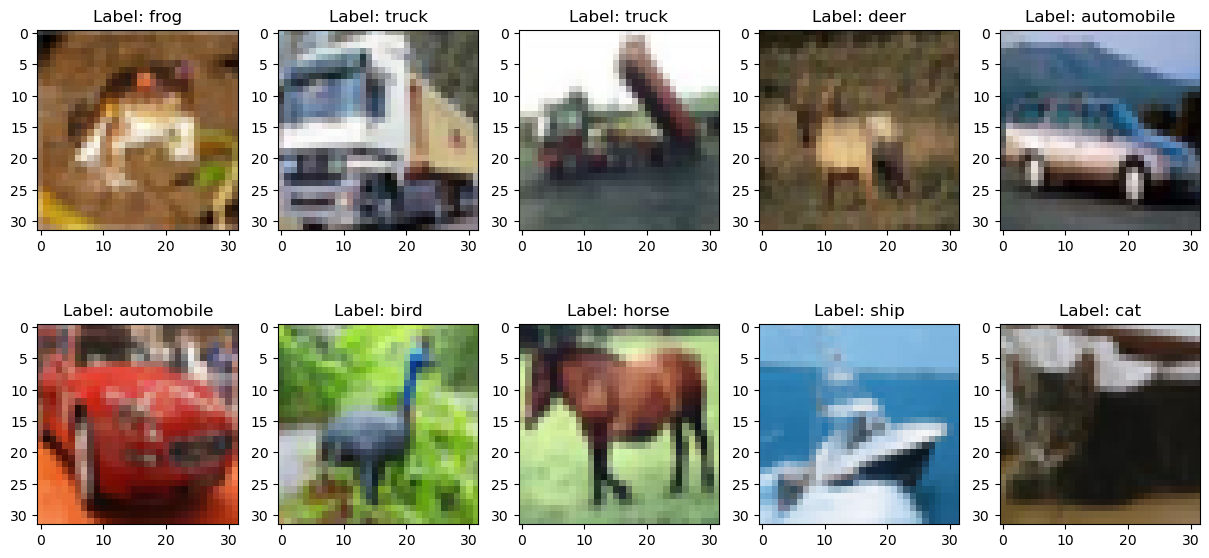

In [4]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_train[:10], y_train[:10])):
  ax[i].imshow(image)
  ax[i].set_title(f"Label: {class_name[label.argmax()]}",  fontsize=12)

## **Training Model**

Create a ResNet-18 model using Keras API. ResNet-18 is a convolutional neural network with 18 layers, designed to address the vanishing gradient problem using residual blocks. These blocks include shortcut connections that allow gradients to flow more easily during training, making it effective for image classification tasks. Afterwards, the model is compiled with an optimizer, loss function, and metrics.

In [5]:
class Residual(tf.keras.Model):
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, padding='same', kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, kernel_size=3, padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(
                num_channels, kernel_size=1, strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

b2 = ResnetBlock(64, 2, first_block=True,)
b3 = ResnetBlock(128, 2)
b4 = ResnetBlock(256, 2)
b5 = ResnetBlock(512, 2)

def net():
    model = tf.keras.Sequential([
        # The following layers are the same as b1 that we created earlier
        tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', input_shape=(32,32,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        # The following layers are the same as b2, b3, b4, and b5 that we
        # created earlier
        b2,
        b3,
        b4,
        b5,
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=10, activation='softmax')])

    # loss= tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    # optimizer=tf.optimizers.legacy.Adam(learning_rate=0.0001)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [6]:
model = net()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 32, 32, 64)        4864      
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  (None, 16, 16, 64)        148736    
                                                  

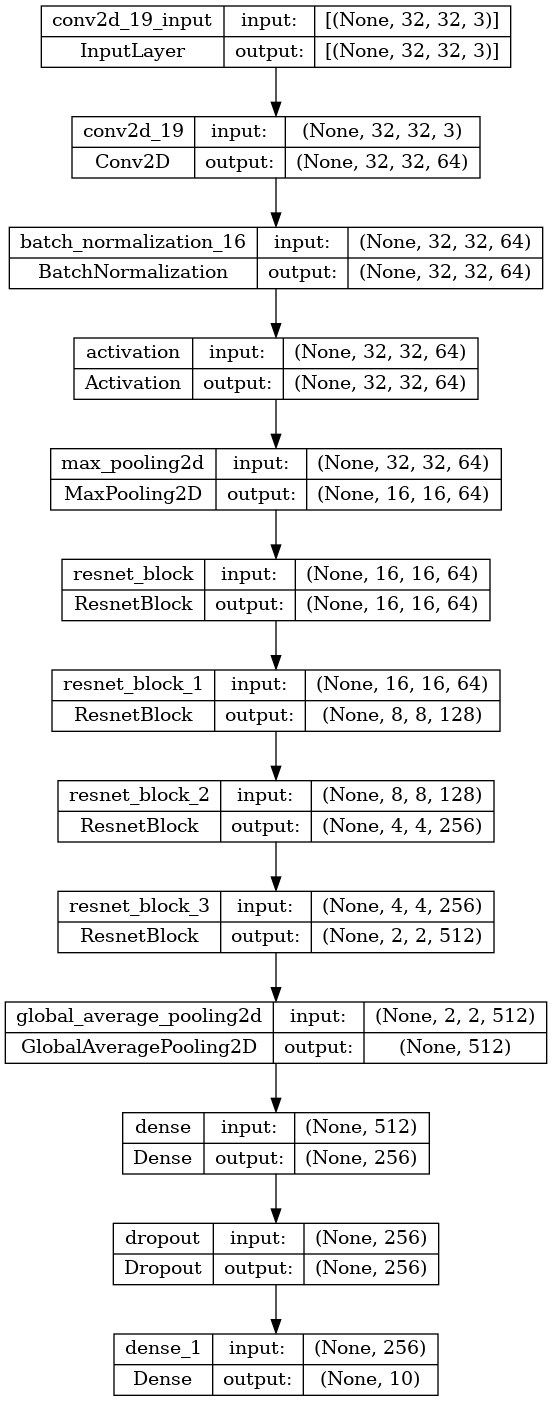

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [8]:
# Save/Load the model 
# model.save('./../models/cifar10_resnet18.tf')
model = tf.keras.models.load_model('./../models/cifar10_resnet18.tf')
model.summary()

2024-05-29 13:53:47.488217: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45977 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:73:00.0, compute capability: 7.5
2024-05-29 13:53:47.677141: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2024-05-29 13:53:48.736398: W tensorflow/c/c_api.cc:291] Operation '{name:'AssignVariableOp_96' id:3268 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_96}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](resnet_block_1/residual_2/conv2d_5/bias/v, Identity_96)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 32, 32, 64)        4864      
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  (None, 16, 16, 64)        148736    
                                                                 
 resnet_block_1 (ResnetBlock  (None, 8, 8, 128)        5

#### Evaluate model accuracy on test data.

In [9]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

2024-05-29 13:53:53.606495: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_1/mul' id:3787 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-29 13:53:54.683113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902


Accuracy on test data: 75.09%


In [10]:
x_test_pred = np.argmax(model.predict(x_test), axis = 1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test, axis = 1))

print('Original test Data: ')
print('Correctly Classified: {}'.format(nb_correct_pred))
print('Incorrectly Classified: {}'.format(len(x_test) - nb_correct_pred))

2024-05-29 13:54:11.014809: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_1_1/Softmax' id:3711 op device:{requested: '', assigned: ''} def:{{{node dense_1_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Original test Data: 
Correctly Classified: 7509
Incorrectly Classified: 2491


### Create a ART Keras classifier for the TensorFlow Keras model.

In [11]:
classifier = KerasClassifier(model= model, clip_values=(0, 1))

## **SimBA Attack**

class art.attacks.evasion.SimBA(classifier: CLASSIFIER_TYPE, attack: str = 'dct', max_iter: int = 3000, order: str = 'random', epsilon: float = 0.1, freq_dim: int = 4, stride: int = 1, targeted: bool = False, batch_size: int = 1, verbose: bool = True)

---

This class implements the black-box attack SimBA.
* Paper link: https://arxiv.org/abs/1905.07121

*__init__(classifier: CLASSIFIER_TYPE, attack: str = 'dct', max_iter: int = 3000, order: str = 'random', epsilon: float = 0.1, freq_dim: int = 4, stride: int = 1, targeted: bool = False, batch_size: int = 1, verbose: bool = True)*

**Create a SimBA (dct) attack instance.**

    Parameters
* classifier – A trained classifier predicting probabilities and not logits.
* attack (str) – attack type: pixel (px) or DCT (dct) attacks
* max_iter (int) – The maximum number of iterations.
* epsilon (float) – Overshoot parameter.
* order (str) – order of pixel attacks: random or diagonal (diag)
* freq_dim (int) – dimensionality of 2D frequency space (DCT).
* stride (int) – stride for block order (DCT).
* targeted (bool) – perform targeted attack
* batch_size (int) – Batch size (but, batch process unavailable in this implementation)
* verbose (bool) – Show progress bars.


    diagonal_order(image_size, channels)
Defines a diagonal order for pixel attacks. order is fixed across diagonals but are randomized across channels and within the diagonal e.g. [1, 2, 5] [3, 4, 8] [6, 7, 9]

    Parameters
* image_size – image size (i.e., width or height)
* channels – the number of channels

    
    Return order
* An array holding the diagonal order of pixel attacks.

    
    generate(x: ndarray, y: Optional[ndarray] = None, **kwargs) → ndarray
Generate adversarial samples and return them in an array.

    Return type
* ndarray
    
    
    Parameters
* x (ndarray) – An array with the original inputs to be attacked.
* y – An array with the true or target labels.

    
    Returns
* An array holding the adversarial examples.

Link: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#simple-black-box-adversarial-attack

### Create SimBA attack

In [12]:
attack = SimBA(classifier = classifier,
              attack = 'dct',
              max_iter = 1000,
              order = 'random',
               epsilon = 0.1,
               freq_dim = 4,
               stride = 1,
               targeted = False,
               batch_size = 1,
                verbose = False)

In [13]:
x_test = x_test[:500]
y_test = y_test[:500]

### Generate adversarial test data.

In [15]:
x_test_adv = attack.generate(x_test, y=y_test)

In [16]:
# Save and load generated adversairial data. 
# np.savez('./SimBA_data/SimBA_cifar-10_generated_data.npz', x_test_adv = x_test_adv, y_test = y_test)
data = np.load('./SimBA_data/SimBA_cifar-10_generated_data.npz')
x_test_adv, y_test = data['x_test_adv'], data['y_test']
x_test_adv.shape, y_test.shape

((500, 32, 32, 3), (500, 10))

Visualise the first adversarial test sample.

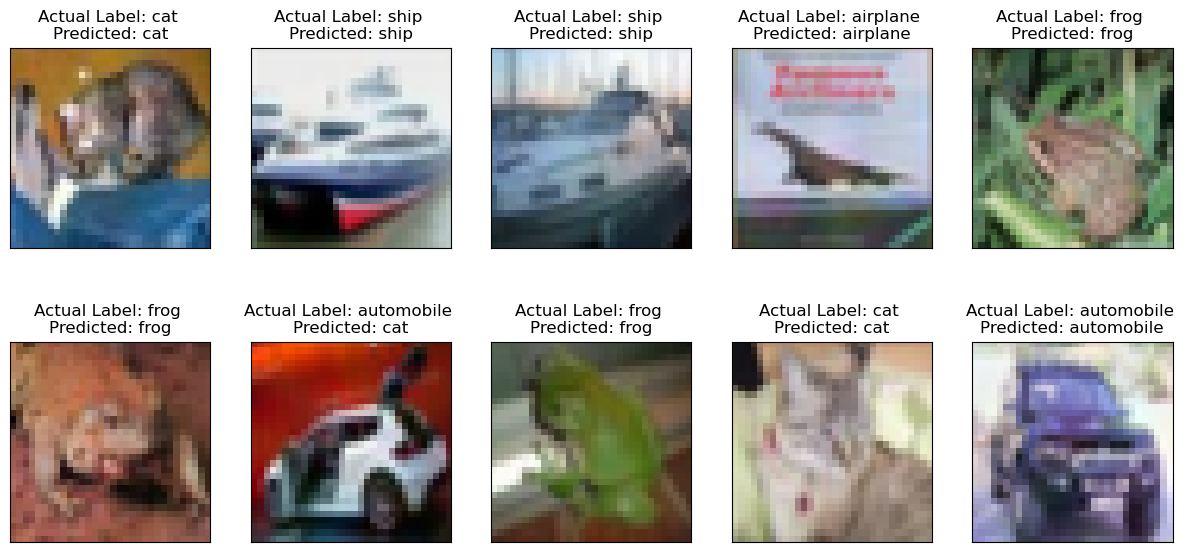

In [17]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_test_adv[:10], y_test[:10])):
  #im_idx = np.argwhere(y_train == i)[0]
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {class_name[label.argmax()]} \nPredicted: {class_name[model.predict(np.expand_dims(image, axis=0)).argmax()]}",  fontsize=12)


#### Evaluate the trained model

In [21]:
# loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)

x_test_pred = np.argmax(model.predict(x_test), axis = 1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test, axis = 1))
accuracy_test = nb_correct_pred / x_test_adv.shape[0]
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 74.20%
Average perturbation: 0.01


Training the Detector

We create the second model using Keras API with the same strucure of the classifier. Here we use the Keras Sequential model and add a sequence of layers. Afterwards the model is compiles with optimizer, loss function and metrics. This model will be used to classify between ordinary samples and perturbated ones

In [48]:
class Residual(tf.keras.Model):
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, padding='same', kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, kernel_size=3, padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(
                num_channels, kernel_size=1, strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

b2 = ResnetBlock(64, 2, first_block=True,)
b3 = ResnetBlock(128, 2)
b4 = ResnetBlock(256, 2)
b5 = ResnetBlock(512, 2)

def detector():
    model = tf.keras.Sequential([
        # The following layers are the same as b1 that we created earlier
        tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', input_shape=(32,32,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        # The following layers are the same as b2, b3, b4, and b5 that we
        # created earlier
        b2,
        b3,
        b4,
        b5,
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=10, activation='softmax')])

    # loss= tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    # optimizer=tf.optimizers.legacy.Adam(learning_rate=0.0001)

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [49]:
detector_model = detector()
detector_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_141 (Conv2D)         (None, 32, 32, 64)        4864      
                                                                 
 batch_normalization_120 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_8 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 resnet_block_24 (ResnetBloc  (None, 16, 16, 64)       148736    
 k)                                                              
                                                      

In [41]:
# x_train_adv = attack.generate(x_train[:500])
# nb_train = x_train[:500].shape[0]

# x_train_detector = np.concatenate((x_train[:500], x_train_adv), axis=0)
# y_train_detector = np.concatenate((np.array([[1,0]]*nb_train), np.array([[0,1]]*nb_train)), axis=0)

In [42]:
detector_data = np.load('./SimBA_data/SimBA_detector_CIFAR10_data.npz')
x_train_detector, y_train_detector = detector_data['x_train_detector'], detector_data['y_train_detector']
x_train_detector.shape , y_train_detector.shape

((1000, 32, 32, 3), (1000, 2))

In [51]:
detector_model.fit(x_train_detector, y_train_detector, batch_size=32, epochs=10)

Evaluate the adversarial generated data

In [29]:
nb_test = x_test.shape[0]

x_test_detector = np.concatenate((x_test, x_test_adv), axis=0)
y_test_detector = np.concatenate((np.array([[1,0]]*nb_test), np.array([[0,1]]*nb_test)), axis=0)
x_test_detector.shape, y_test_detector.shape

((1000, 32, 32, 3), (1000, 2))

In [30]:
loss_test, accuracy_test = detector_model.evaluate(x_test_detector, y_test_detector)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

2024-05-23 12:09:41.191493: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_1/mul' id:4580 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_3_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy on test data: 50.70%


In [31]:
detector_classifier = KerasClassifier(clip_values=(0.0, 0.1), model=detector_model, use_logits=False)
detector = BinaryInputDetector(detector_classifier)

In [32]:
detector.fit(x_train_detector, y_train_detector, nb_epochs=3, batch_size=32)

### Evaluating the detector

Apply the detector to the adversarial test data:

In [33]:
_, is_adversarial = detector.detect(x_test_adv[:100])
flag_adv = np.sum(is_adversarial)

print("Adversarial test data (first 100 images):")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(100 - flag_adv))

2024-05-23 12:09:58.378220: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_3/Softmax' id:4504 op device:{requested: '', assigned: ''} def:{{{node dense_3/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_3/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Adversarial test data (first 100 images):
Flagged: 29
Not flagged: 71


Apply the detector to the first 100 original test images:

In [34]:
_, is_adversarial = detector.detect(x_test[:100])
flag_original = np.sum(is_adversarial)

print("Original test data (first 100 images):")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(100 - flag_original))

Original test data (first 100 images):
Flagged: 28
Not flagged: 72


Evaluate the detector for different attack strengths learning_rate (Note: for the training of detector, learning_rate=0.01 was used)

In [35]:
epsilon_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3]
nb_flag_adv = []
nb_missclass = []


attack.set_params(**{'max_iter' : 10})

for rate in epsilon_range:
    attack.set_params(**{'epsilon': rate})
    x_test_adv = attack.generate(x_test[:100])
    nb_flag_adv += [np.sum(detector.detect(x_test_adv)[1])]
    nb_missclass += [np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test[:100], axis=1))]

eps_range = [0] + epsilon_range
nb_flag_adv = [flag_original] + nb_flag_adv
nb_missclass = [2] + nb_missclass

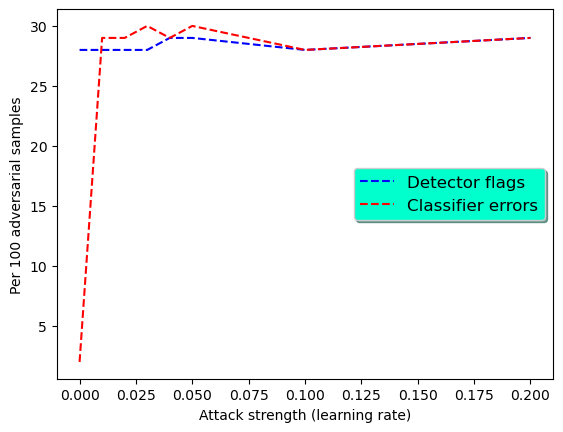

In [36]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range)[:8], np.array(nb_flag_adv)[:8], 'b--', label='Detector flags')
ax.plot(np.array(eps_range)[:8], np.array(nb_missclass)[:8], 'r--', label='Classifier errors')

legend = ax.legend(loc='center right', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (learning rate)')
plt.ylabel('Per 100 adversarial samples')
plt.show()

### **Summary**


**Simple Black-box Adversarial Attack (SimBA) and Binary Input Detector Using CIFAR-10**

This notebook demonstrates the implementation of the SimBA attack using the ART library against a ResNet-18 model trained on the CIFAR-10 dataset. The tasks covered include:

1. Load the Required Libraries: Import necessary Python libraries.
2. Load the Dataset and Inspect the Data: Load and visualize the CIFAR-10 dataset.
3. Create a Deep Learning Model: Construct and compile a ResNet-18 model.
4. Train and Evaluate the Model: Train the model on CIFAR-10 and evaluate its accuracy.
5. Implement SimBA Attack: Use ART to perform the SimBA attack, which perturbs images by flipping pixel signs based on model queries.
6. Create Adversarial Samples: Generate adversarial examples using SimBA.
7. Evaluate Against Adversarial Samples: Test the model's robustness on the adversarial samples.
8. Create a Detector Model: Develop a binary classifier to detect adversarial inputs.
9. Train and Evaluate the Detector: Train and assess the detector's accuracy in identifying adversarial samples.

This summary highlights the implementation and evaluation of the SimBA attack to test and improve model robustness.